### AI Model - Retinanet

In this section of the notebook, it will investigate the performance of Retinanet when being trained against the public dataset "AgroPest-12". 

Since Retinanet does not take YOLO formats directly, the YOLO format requires pre-processing and converted into useable data.

In [2]:
import torch
from PIL import Image

def yolo_converter(path, width, height):
    annots = []
    labels = []
    with open(path) as f:
        for line in f.readlines():
            class_id, x, y, w, h = map(float, line.strip().split())
            x_min = (x - w/2) * width
            y_min = (y - h/2) * height
            x_max = (x + w/2) * width
            y_max = (y + h/2) * height
            annots.append([x_min, y_min, x_max, y_max])
            labels.append(int(class_id) + 1)

    if len(annots) == 0:
        annots = torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.zeros((0,), dtype=torch.int64)
    else:
        annots = torch.tensor(annots, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
    return annots, labels

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToTensor(),
])


class ImgDataset(Dataset):
    def __init__(self, path, label_path, trans=None):
        self.path = path
        self.label_path = label_path
        self.trans = trans

    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        img_path = self.path[index]
        label_path = self.label_path[index]
        
        img = Image.open(img_path).convert("RGB")
        wid, height = img.size
        try:
            annots, labels = yolo_converter(label_path, wid, height)
        except:
            print("Path Not found!")
            exit(1)

        if self.trans:
            img = self.trans(img)
        target = {"boxes": annots, "labels": labels}
        
        return img, target

Once the data is paths and labels are pre-processed correctly, the data can be allocated to training, validation and testing sets.

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from glob import glob
 
test_img = sorted(glob("../2/test/images/*.jpg"))
test_lab = sorted(glob("../2/test/labels/*.txt"))
test = ImgDataset(test_img, test_lab, trans=trans)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Successfully Initialsed datas")


Successfully Initialsed datas


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = DataLoader(test, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)

print("Successfully loaded the image data into data sets")

Successfully loaded the image data into data sets


Once the data is loaded into data loader, the AI model can begain training.

In [6]:
weight = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weight)

classes = 12 + 1 # 1 more to accommodate the background
in_feature = model.head.classification_head.cls_logits.in_channels
num_anchors = model.head.classification_head.num_anchors

model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_feature,
    num_anchors=num_anchors,
    num_classes=classes
)

print("Initialised Retinanet Model!")


Initialised Retinanet Model!


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

y_true = []
y_pred = []

metric = MeanAveragePrecision(class_metrics=True)
metric.to(device)

model.load_state_dict(torch.load('../retinanet_weights_og.pth', map_location=device))
model.to(device)
model.eval()
metric.reset()

score_threshold = 0.5

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        preds = model(images)
        
        targets2 = [{k: v.to(device) for k, v in t.items()} for t in targets]

        metric.update(preds, targets2)

        for pred, target in zip(preds, targets):
            y_true.extend([1]*len(target['boxes']))
            y_pred.extend([1]*(pred['scores'] > score_threshold).sum().item())

            diff = len(target['boxes']) - (pred['scores'] > score_threshold).sum().item()
            if diff > 0:
                y_pred.extend([0]*diff)
            elif diff < 0:
                y_true.extend([0]*(-diff))

res = metric.compute()
print(res)
print()

/home/james/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


{'map': tensor(0.3610), 'map_50': tensor(0.6525), 'map_75': tensor(0.3771), 'map_small': tensor(-1.), 'map_medium': tensor(0.0235), 'map_large': tensor(0.3782), 'mar_1': tensor(0.4390), 'mar_10': tensor(0.5073), 'mar_100': tensor(0.5110), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.0769), 'mar_large': tensor(0.5393), 'map_per_class': tensor([0.2510, 0.4049, 0.2427, 0.1304, 0.1619, 0.2643, 0.1770, 0.7230, 0.2363,
        0.5449, 0.5818, 0.6134]), 'mar_100_per_class': tensor([0.3920, 0.5182, 0.5045, 0.3097, 0.3575, 0.4507, 0.3527, 0.7745, 0.4588,
        0.6960, 0.6447, 0.6724]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)}



In [7]:
from sklearn.metrics import confusion_matrix
from torchvision.ops import box_iou

y_true_cm = []
y_pred_cm = []

iou_thresh = 0.5
model.load_state_dict(torch.load('../retinanet_weights_og.pth', map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        preds = model(images)

        for pred, target in zip(preds, targets):
            pboxes = pred['boxes'].cpu()
            plabels = pred['labels'].cpu()
            gboxes = target['boxes']
            glabels = target['labels']

            for gbox, glab in zip(gboxes, glabels):
                # Find best IoU prediction for this ground truth
                ious = box_iou(gbox.unsqueeze(0), pboxes)[0]
                best_iou, best_pi = torch.max(ious, dim=0)

                # Only keep MATCHED boxes
                if best_iou >= iou_thresh:
                    y_true_cm.append(glab.item())
                    y_pred_cm.append(plabels[best_pi].item())

In [9]:
import numpy as np

y_true_np = np.array(y_true_cm)
y_pred_np = np.array(y_pred_cm)
cm = confusion_matrix(y_true_np, y_pred_np)
# print(y_pred_np[:100])
# print(y_true_np[:100])
print(cm)
len(test_loader.dataset)

[[36  6  7  2  1 14  2  0  0  0  8  0]
 [ 6 17  2  7  0  2  1  1  0  1  7  0]
 [ 5  2  8  4  2  7  0  0  7  3  1  4]
 [ 0  2  2 23  5  7  6  2  9  4  3  0]
 [ 0  0  0  3 16  8  0  0  4  1  0  0]
 [14  1 12  1 12 15  5  1  1  2  0  1]
 [ 7  0  0 10  4  6 11  2  4  2  3  0]
 [ 0  0  2  2  0  1  3 31  4  1  1  2]
 [ 0  0  2  2  9  7  3  1 11 11  1  0]
 [ 0  0  3  0  0  0  0  2  6 36  0  3]
 [ 3  6  0  1  0  0  3  3  0  0 29  2]
 [ 1  2 11  0  0  3  0  4  0  2  2 32]]


546

In [12]:
import pprint

insects = ['Ants', 'Bees', 'Beetles', 'Caterpullars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']
mAP = res["map"].item()
recall = res["mar_100"].item() 

mAPs = []
recalls = []
print(f"Performance mAP: {mAP:.4f}")
for x in range(len(res['map_per_class'])):
    print(f"{insects[x]}: {res['map_per_class'][x]:.4f}")
    mAPs.append(res['map_per_class'][x])

print() 
print(f"MAR@100 : {recall:.4f}")
for x in range(len(res['mar_100_per_class'])):
    print(f"{insects[x]}: {res['mar_100_per_class'][x]:.4f}")
    recalls.append(res['mar_100_per_class'][x])

print()
print()
print("Full metrics:")
pprint.pprint(res)


Performance mAP: 0.3610
Ants: 0.2510
Bees: 0.4049
Beetles: 0.2427
Caterpullars: 0.1304
Earthworms: 0.1619
Earwigs: 0.2643
Grasshoppers: 0.1770
Moths: 0.7230
Slugs: 0.2363
Snails: 0.5449
Wasps: 0.5818
Weevils: 0.6134

MAR@100 : 0.5110
Ants: 0.3920
Bees: 0.5182
Beetles: 0.5045
Caterpullars: 0.3097
Earthworms: 0.3575
Earwigs: 0.4507
Grasshoppers: 0.3527
Moths: 0.7745
Slugs: 0.4588
Snails: 0.6960
Wasps: 0.6447
Weevils: 0.6724


Full metrics:
{'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32),
 'map': tensor(0.3610),
 'map_50': tensor(0.6525),
 'map_75': tensor(0.3771),
 'map_large': tensor(0.3782),
 'map_medium': tensor(0.0235),
 'map_per_class': tensor([0.2510, 0.4049, 0.2427, 0.1304, 0.1619, 0.2643, 0.1770, 0.7230, 0.2363,
        0.5449, 0.5818, 0.6134]),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.4390),
 'mar_10': tensor(0.5073),
 'mar_100': tensor(0.5110),
 'mar_100_per_class': tensor([0.3920, 0.5182, 0.5045, 0.3097, 0.3575, 0.4507, 0.3527, 0.77

In [13]:
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score

precision = precision_score(y_true_cm, y_pred_cm, average='macro')
recall = recall_score(y_true_cm, y_pred_cm, average='macro')
acc = accuracy_score(y_true_cm, y_pred_cm)
f1 = f1_score(y_true_cm, y_pred_cm, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Precision: 0.4286
Accuracy: 0.4274
Recall: 0.4299
F1 score: 0.4244


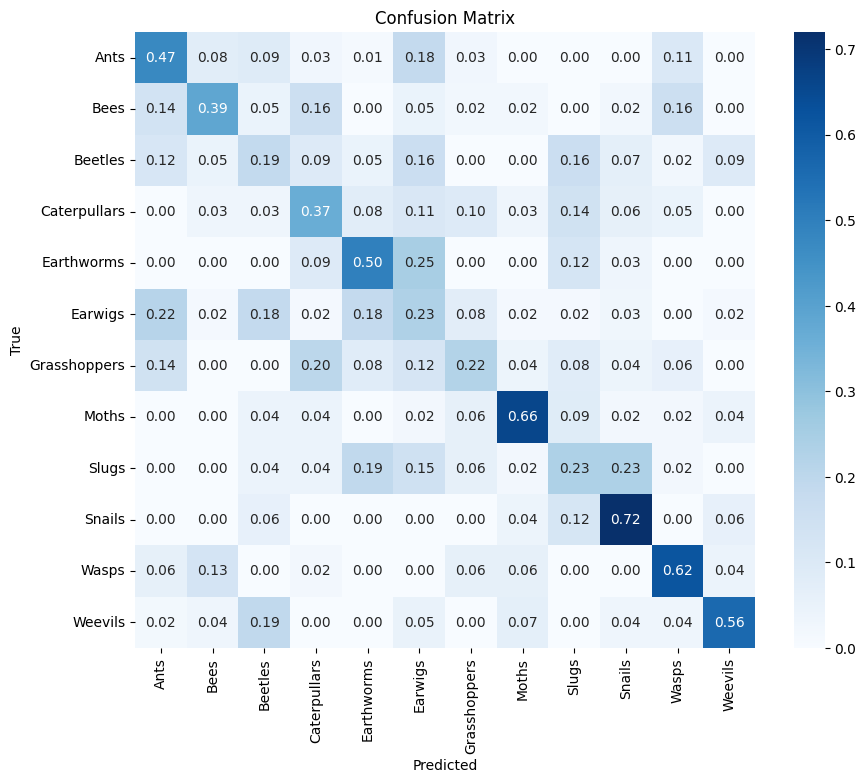

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
insects = ['Ants', 'Bees', 'Beetles', 'Caterpullars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=insects, yticklabels=insects)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('Retinanet50.png')
plt.show()